## Load the Dataset

##### Dataset Folder Structure
```plaintext
Dataset/
   ├── class1/
   │   ├── image1.jpg
   │   ├── image2.jpg
   └── class2/
       ├── image3.jpg
       ├── image4.jpg


In [1]:
import os
from sklearn import preprocessing # type: ignore

import pandas as pd # type: ignore
from PIL import Image # type: ignore
from torchvision.io import read_image # type: ignore
import torchvision.transforms as transforms # type: ignore
from torch.utils.data import DataLoader, Dataset # type: ignore

In [2]:
def load_dataset(root='D:/yogi/shoppin/ImageNet-Mini/augmented_images_200'):
  
  """
    Loads the dataset from the specified root directory and returns image file paths
    and their corresponding encoded labels.

  """
  img_paths= []
  labels= []

  for dir, folder, files in os.walk(root):

    for file in files:
      img_path= os.path.join(dir, file)
      img_paths.append(img_path)
      labels.append(os.path.basename(dir))


  label_encoder= preprocessing.LabelEncoder()
  img_ids= label_encoder.fit_transform(labels)

  return img_paths, img_ids

In [3]:
img_paths, img_ids= load_dataset()

## Dataset Split

In [4]:
from math import floor
import random

def split_data(img_paths, img_ids, ratio= 0.8):

    """
    Splits the dataset into training and testing subsets based on the specified ratio
    """

    # Combine data and labels into a list of tuples
    combined = list(zip(img_paths, img_ids))

    random.seed(42)

    # Shuffle the combined list
    random.shuffle(combined)

    # Split the shuffled combined list into two lists
    split_index = floor(len(combined) * ratio)

    train_combined  = combined[:split_index]
    test_combined   = combined[split_index:]

    # Unpack the combined tuples into separate paths and labels
    train_img_paths, train_img_ids   = zip(*train_combined)
    test_img_paths, test_img_ids     = zip(*test_combined)


    return train_img_paths, train_img_ids, test_img_paths, test_img_ids

In [5]:
train_img_paths, train_img_ids, test_img_paths, test_img_ids= split_data(img_paths, img_ids)

## Segment the data

In [14]:
import cv2
import torch
import numpy as np
from ultralytics import YOLO

In [11]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
# Load the YOLO segmentation model
seg_model = YOLO('yolov8n-seg.pt').to(device)

In [16]:
def masked_image(image_path, segment_model):
    """
    Applies a segmentation model to detect objects in an image, generates a mask for detected areas, 
    and returns an image with the background masked out (set to black), leaving the objects unmasked.

    Args:
        image_path (str): The file path to the input image.
        segment_model (torch.nn.Module): A PyTorch segmentation model capable of detecting objects 
            and generating masks for them.

    Returns:
        PIL.Image.Image: The masked image where the background is blacked out, and the detected objects 
        remain visible. If no objects are detected, the original image is returned.
    """
    objects_detected = 0

    # Load and preprocess the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_height, original_width = image.shape[:2]
    # Resize the image to a valid shape for YOLO
    image_resized = cv2.resize(image, (640, 640))
    # Convert to tensor and normalize
    image_tensor = torch.tensor(image_resized, dtype=torch.float32).permute(2, 0, 1) / 255.0  # Shape: (3, 640, 640)
    image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension: (1, 3, 640, 640)

    # Move the model to the device
    segment_model = segment_model.to(device)
    # Perform segmentation
    results = segment_model(image_tensor)

    if results[0].masks is not None:
        # Extract masks
        masks = results[0].masks.data.cpu().numpy()

        # Combine masks (union of all masks)
        combined_mask = np.any(masks, axis=0)

        # Resize mask to match original image dimensions
        resized_mask = cv2.resize(combined_mask.astype(np.uint8), (original_width, original_height), interpolation=cv2.INTER_NEAREST)
        resized_mask = resized_mask.astype(bool)  # Convert back to boolean

        # Apply mask to image to keep only the detected objects
        masked_image = image.copy()
        masked_image[~resized_mask] = 0  # Set background regions to black
        objects_detected += 1
        print(f'Objects detected: {objects_detected}')
    else:
        # If no masks are found, use the original image
        masked_image = image

    # Convert NumPy array to PIL Image
    masked_image = Image.fromarray(masked_image)

    return masked_image


In [17]:
# segment training data images and mask up the background
training_mask_data= []

for img_path in train_img_paths:
    training_mask_data.append(masked_image(img_path, seg_model))


0: 640x640 1 cat, 20.4ms
Speed: 0.0ms preprocess, 20.4ms inference, 86.1ms postprocess per image at shape (1, 3, 640, 640)
Objects detected: 1

0: 640x640 1 bird, 14.0ms
Speed: 0.0ms preprocess, 14.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)
Objects detected: 1

0: 640x640 (no detections), 16.0ms
Speed: 0.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.0ms
Speed: 0.0ms preprocess, 13.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.0ms
Speed: 0.0ms preprocess, 13.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 15.0ms
Speed: 1.0ms preprocess, 15.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.0ms
Speed: 0.0ms preprocess, 13.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)
Objects detected: 1

0: 640x640 (no detections), 12.0m

In [18]:
# segment test data images and mask up the background
test_mask_data= []

for img_path in test_img_paths:
    test_mask_data.append(masked_image(img_path, seg_model))


0: 640x640 1 banana, 16.5ms
Speed: 0.0ms preprocess, 16.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)
Objects detected: 1

0: 640x640 1 bed, 15.0ms
Speed: 0.0ms preprocess, 15.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)
Objects detected: 1

0: 640x640 (no detections), 14.3ms
Speed: 0.0ms preprocess, 14.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 horse, 14.0ms
Speed: 0.0ms preprocess, 14.0ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)
Objects detected: 1

0: 640x640 (no detections), 14.8ms
Speed: 0.0ms preprocess, 14.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 14.7ms
Speed: 0.0ms preprocess, 14.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.0ms
Speed: 0.0ms preprocess, 14.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)
Objects detected: 1

0: 640x640

## Dataloader

In [19]:
def transform_image():

  '''
  transformation for training images
  '''
  
  transform= transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.RandomResizedCrop(224),
      transforms.ToTensor(),
      transforms.Lambda(lambda img: img.repeat(3, 1, 1) if img.shape[0] == 1 else img),
      transforms.Normalize(mean=0.5,  # Standard ImageNet normalization
      std=0.5)
  ])

  return transform

In [20]:
def transform_test_image():

  '''
  transformation for test images
  '''
  
  transform= transforms.Compose([
      transforms.Resize(224),
      transforms.ToTensor(),
      transforms.Lambda(lambda img: img.repeat(3, 1, 1) if img.shape[0] == 1 else img),
      transforms.Normalize(mean=0.5,  # Standard ImageNet normalization
      std=0.5)
  ])

  return transform

In [21]:
class MaskedDataset(Dataset):
    def __init__(self, masked_image, labels, transform=None):
        self.masked_image= masked_image
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.masked_image)

    def __getitem__(self, idx):
        masked_image= self.masked_image[idx]

        # Apply transformations (if any)
        if self.transform:
            masked_image = self.transform(masked_image)

        # Get label
        label = self.labels[idx]

        return masked_image, label

In [22]:
training_data   = MaskedDataset(training_mask_data, train_img_ids, transform_image())
val_data        = MaskedDataset(test_mask_data, test_img_ids, transform_test_image())

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)

## Model Configuration

In [37]:
from torchvision.models import resnet50, resnet34
import torch.nn as nn
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
from torch.nn import CrossEntropyLoss

In [24]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'

In [25]:
model= resnet34(weights= True)

c:\Users\ShivajiWankhede\anaconda3\envs\llm\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
in_features= 512
classes= 200

model.fc= nn.Sequential(nn.Linear(in_features, classes))

In [40]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
criteria= CrossEntropyLoss()

# Define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=0.5)  # Reduces LR by 10x every 10 epochs

## Training & Testing

In [28]:
model= model.to(device)

In [39]:
def Train(model, train_dataloader, epoch):
  model.train()
  loss_running= 0
  total= 0
  correct= 0

  for idx, (inputs, labels) in enumerate(train_dataloader):
    inputs= inputs.to(device)
    labels= labels.to(device)
    outputs= model(inputs)

    loss = criteria(outputs, labels)
    loss_running += loss

    optimizer.zero_grad()
    # loss.requires_grad = True
    loss.backward()
    optimizer.step()

    _, predicted = outputs.max(1)

    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()

    # print(f'Epoch {epoch + 1}: Batch idx: {idx}/{len(train_dataloader)} train accuracy: {correct/total} | train loss: {loss}')

  # Step the learning rate scheduler
  scheduler.step()

  print(f'Epoch {epoch + 1}: train accuracy: {correct/total} | train loss: {loss_running/len(train_dataloader)}')

In [33]:
def Test(model, test_dataloader, epoch=0):
    model.eval()
    total= 0
    correct= 0
    predictions= []
    true_labels= []

    for input, labels in test_dataloader:
        input= input.to(device)
        labels= labels.to(device)
        outputs= model(input)

        _, predicted = outputs.max(1)
        predictions.extend(predicted)
        true_labels.extend(labels)

        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f'Epoch: {epoch + 1} | test accuracy: {correct/total}')

In [41]:
epochs= 5

for i in range(epochs):
    Train(model, train_dataloader, i)
    Test(model, val_dataloader, i)

Epoch 1: train accuracy: 0.8914868321504485 | train loss: 0.5122944712638855
Epoch: 1 | test accuracy: 0.9262247838616715
Epoch 2: train accuracy: 0.9090679828511726 | train loss: 0.4286305904388428
Epoch: 2 | test accuracy: 0.9471181556195966
Epoch 3: train accuracy: 0.9191195013870375 | train loss: 0.38550543785095215
Epoch: 3 | test accuracy: 0.9492795389048991
Epoch 4: train accuracy: 0.9229743848398602 | train loss: 0.36777588725090027
Epoch: 4 | test accuracy: 0.9512968299711816
Epoch 5: train accuracy: 0.9286666426487012 | train loss: 0.34390565752983093
Epoch: 5 | test accuracy: 0.9511527377521614


In [42]:
# torch.save(model.state_dict(), './checkpoints/model_with_detector.pth')

## Enrollment

In [43]:
import json

# Convert tensors to lists for serialization
def tensor_to_list(obj):
    if isinstance(obj, torch.Tensor):
        return obj.tolist()  # Convert tensor to list
    raise TypeError(f"Object of type {obj.__class__.__name__} is not serializable")


def enroll_image(image_path, database= './database_cnn_with_detection', model=None, weights= True, transformation= transform_test_image()):

  """
    Processes and enrolls an image by extracting its
    embeddings and saving them to a JSON file inside database
  """

  os.makedirs(database, exist_ok=True)

  image= Image.open(image_path).convert('RGB')
  transformed_image= transformation(image).unsqueeze(0).to(device)

  model= model.to(device)
  model.eval()  
  embeddings= model(transformed_image).reshape(1,-1)
  
  name= os.path.basename(image_path).split('.JPEG')[0] + '.json'
  folder= os.path.basename(os.path.dirname(image_path))
  file_name= folder + '_@_' + name

  output_path= os.path.join(database, file_name)
  value= {image_path: embeddings}

  with open(output_path, 'w') as f:
      json.dump(value, f, default=tensor_to_list)

In [44]:
#load trained model
model.load_state_dict(torch.load('./checkpoints/model_with_detector.pth'))

<All keys matched successfully>

In [45]:
backbone_model = nn.Sequential(*list(model.children())[:-1])

In [46]:
#Enrolling all training images to database

for i, path in enumerate(train_img_paths):
    print(i)
    enroll_image( path, model= backbone_model)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

## Evaluation

In [47]:
import requests # type: ignore
from io import BytesIO

from sklearn.metrics.pairwise import cosine_similarity # type: ignore
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore

In [48]:
def download_image(url):
    response = requests.get(url)
    response.raise_for_status()  # Raise an exception for HTTP errors
    
    # Open the image from the response content
    img = Image.open(BytesIO(response.content))

    return img

In [49]:
def precision_at_k(image_path=None, url= None, model= None, database_folder='./database_cnn_with_detection', k=1, transformation= transform_test_image()):
    
    """
    Computes Precision@K for an input image or URL against a database of embeddings

    Args:
        image_path (str, optional): Path to the probe image for comparison. 
                                    Required if `url` is not provided. Default is None.
        url (str, optional): URL of the probe image for comparison. Used if `image_path` is not provided. Default is None.
        model (torch.nn.Module, optional): Pre-trained feature extraction model. If None, a ResNet34 model with pre-trained weights is used. 
                                           Default is None.
        database_folder (str, optional): Path to the folder containing JSON files with embeddings. Default is './database_cnn_200'.
        k (int, optional): The number of top results to consider for Precision@K. Default is 1.
        transformation (callable, optional): Transformation function applied to the probe image before feature extraction. 
                                             Default is `transform_image()`.

    Returns:
        float: The precision score for the top `k` results, calculated as:
               Precision@K = (Number of true positives in top `k` results) / `k`
               
    """

    device= 'cuda' if torch.cuda.is_available() else 'cpu'

    probe_label= os.path.basename(os.path.dirname(image_path))

    if url== None:
        image= Image.open(image_path)
        transformed_image= transformation(image).unsqueeze(0).to(device)
    else:
        image= download_image(url)
        transformed_image= transformation(image).unsqueeze(0).to(device)


    model= model.to(device)
    model.eval()

    with torch.no_grad():
        query_embedding= model(transformed_image).reshape(1,-1).cpu()


    # Load all database embeddings into memory
    database_embeddings = []
    labels = []

    for json_file in os.listdir(database_folder):
        if json_file.endswith('.json'):
            json_path = os.path.join(database_folder, json_file)
            
            with open(json_path, 'r') as file:
                database = json.load(file)
            
            for path, emb in database.items():
                folder = os.path.basename(os.path.dirname(path))
                labels.append(folder)
                database_embeddings.append(torch.tensor(emb).numpy())

    # Convert embeddings and query to NumPy arrays
    database_embeddings = np.vstack(database_embeddings)
    query_embedding = query_embedding.numpy()

    # Compute cosine similarity in a batch
    similarities = cosine_similarity(database_embeddings, query_embedding)

    # Combine labels and similarities, then get top-k
    labeled_scores = list(zip(labels, similarities[:, 0]))
    top_k_scores = sorted(labeled_scores, key=lambda x: x[1], reverse=True)[:k]

    # Calculate Precision@k
    true_positive = sum(1 for label, _ in top_k_scores if label == probe_label)
    precision = true_positive / k

    print(f'Precision@k={k}: {precision}')


    return precision    

In [50]:
def recall_at_k(image_path=None, url= None, model= None, database_folder='./database_cnn_with_detection', k=1, transformation= transform_test_image()):
    
    """
    Computes Recall@K for an input image or URL against a database of embeddings.

    Args:
        image_path (str, optional): Path to the probe image for comparison. 
                                    Required if `url` is not provided. Default is None.
        url (str, optional): URL of the probe image for comparison. Used if `image_path` is not provided. Default is None.
        model (torch.nn.Module, optional): Pre-trained feature extraction model. If None, a ResNet34 model with pre-trained weights is used. 
                                           Default is None.
        database_folder (str, optional): Path to the folder containing JSON files with embeddings. Default is './database_cnn_200'.
        k (int, optional): The number of top results to consider for Recall@K. Default is 1.
        transformation (callable, optional): Transformation function applied to the probe image before feature extraction. 
                                             Default is `transform_image()`.

    Returns:
        float: The recall score for the top `k` results, calculated as:
               Recall@K = (Number of true positives in top `k` results) / (Total number of relevant items in the database)

    """           

    device= 'cuda' if torch.cuda.is_available() else 'cpu'
         
    probe_label= os.path.basename(os.path.dirname(image_path))

    if url== None:
        image= Image.open(image_path)
        transformed_image= transformation(image).unsqueeze(0).to(device)
    else:
        image= download_image(url)
        transformed_image= transformation(image).unsqueeze(0).to(device)

    if model== None:
        model= resnet34(weights=True)
        model.load_state_dict(torch.load('checkpoints/model_200.pth'))
        model = nn.Sequential(*list(model.children())[:-1])

    model= model.to(device)
    model.eval()

    with torch.no_grad():
        query_embedding= model(transformed_image).reshape(1,-1).cpu()


    # Load all database embeddings into memory
    database_embeddings = []
    labels = []
    True_positive= 0
    Total_relevant_items= 0


    for json_file in os.listdir(database_folder):
        if json_file.endswith('.json'):
            json_path = os.path.join(database_folder, json_file)
            
            with open(json_path, 'r') as file:
                database = json.load(file)
            
            for path, emb in database.items():
                folder = os.path.basename(os.path.dirname(path))

                if folder == probe_label:
                    Total_relevant_items += 1

                labels.append(folder)
                database_embeddings.append(torch.tensor(emb).numpy())

    # Convert embeddings and query to NumPy arrays
    database_embeddings = np.vstack(database_embeddings)
    query_embedding = query_embedding.numpy()

    # Compute cosine similarity in a batch
    similarities = cosine_similarity(database_embeddings, query_embedding)

    # Combine labels and similarities, then get top-k
    labeled_scores = list(zip(labels, similarities[:, 0]))
    sorted_scores = sorted(labeled_scores, key=lambda x: x[1], reverse=True)[:k]


    for i in range(k):
        if sorted_scores[i][0] == probe_label:
            True_positive += 1
    

    recall= True_positive/Total_relevant_items
    print(f'recall@k={k}: {recall}')

    return recall    

In [51]:
# average precision of the model

def calculate_precision(test_image_paths, model, k=10):
    '''
    This function iterates over a list of test image paths, computes the precision at `k` 
    for each image using the `precision_at_k` function, and then calculates the average 
    precision across all test images
    '''

    precision_sum= 0
    count= 0

    for img_path in test_image_paths:
        value= precision_at_k(img_path, model=model, k=k)
        precision_sum += value
        count += 1

    print(f'average precision @ k={k}: {precision_sum/count}')


calculate_precision(test_img_paths[:10], backbone_model)

Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
average precision @ k=10: 1.0


In [52]:
# average precision of the model

def calculate_recall(test_image_paths, model, k=50):
    '''
    This function iterates over a list of test image paths, computes the recall at `k` 
    for each image using the `recall_at_k` function, and then calculates the average 
    recall across all test images
    '''

    recall_sum= 0
    count= 0
    

    for img_path in test_image_paths:
        value= recall_at_k(img_path, model=model, k=k)
        recall_sum += value
        count += 1

    print(f'average recall @ k={k}: {recall_sum/count}')


calculate_recall(test_img_paths[:10], backbone_model)

recall@k=50: 0.45045045045045046
recall@k=50: 0.24875621890547264
recall@k=50: 0.4032258064516129
recall@k=50: 0.31446540880503143
recall@k=50: 0.31645569620253167
recall@k=50: 0.31446540880503143
recall@k=50: 0.25380710659898476
recall@k=50: 0.3937007874015748
recall@k=50: 0.2403846153846154
recall@k=50: 0.30718954248366015
average recall @ k=50: 0.3242901041488966


## Probe

In [55]:
def top_k_matches(image_path=None, url= None, model= None, database_folder='./database_cnn_with_detection', k=1, transformation= transform_test_image()):

    """
    Retrieves & displays the top-k matching images from a database for a given input image or URL
    """

    device= 'cuda' if torch.cuda.is_available() else 'cpu'

    if url== None:
        image= Image.open(image_path)
        transformed_image= transformation(image).unsqueeze(0).to(device)
    else:
        image= download_image(url)
        transformed_image= transformation(image).unsqueeze(0).to(device)


    model= model.to(device)
    model.eval()

    with torch.no_grad():
        query_embedding= model(transformed_image).reshape(1,-1).cpu()


    # Load all database embeddings into memory
    database_embeddings = []
    paths = []

    for json_file in os.listdir(database_folder):
        if json_file.endswith('.json'):
            json_path = os.path.join(database_folder, json_file)
            
            with open(json_path, 'r') as file:
                database = json.load(file)
            
            for path, emb in database.items():
                # folder = os.path.basename(os.path.dirname(path))
                paths.append(path)
                database_embeddings.append(torch.tensor(emb).numpy())

    # Convert embeddings and query to NumPy arrays
    database_embeddings = np.vstack(database_embeddings)
    query_embedding = query_embedding.numpy()

    # Compute cosine similarity in a batch
    similarities = cosine_similarity(database_embeddings, query_embedding)

    # Combine labels and similarities, then get top-k
    labeled_scores = list(zip(paths, similarities[:, 0]))
    top_k_scores = sorted(labeled_scores, key=lambda x: x[1], reverse=True)[:k]


    # Define the grid size (rows and columns)
    rows = k
    cols = 2  # Adjust rows and cols based on `k`


    # Plot the images
    fig, axes = plt.subplots(rows, cols, figsize=(10, 6))

    # If axes is a single object (when k=1), convert it to a 2D array for consistency
    if rows == 1:
        axes = np.array([axes])  # Convert to 2D array with one row

    # Loop through each row to plot input image and the corresponding match
    for i in range(rows):
        # Plot the input image in the first column
        axes[i, 0].imshow(image)
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Input Image')

        # Plot the corresponding top match in the second column
        if i < k:
            retrieved_image = Image.open(top_k_scores[i][0])
            axes[i, 1].imshow(retrieved_image)
            axes[i, 1].axis("off")
            axes[i, 1].set_title(f"Match {i + 1}")
        else:
            axes[i, 1].axis("off")  # Turn off any extra axes

    plt.tight_layout()
    plt.show()
    

    return top_k_scores

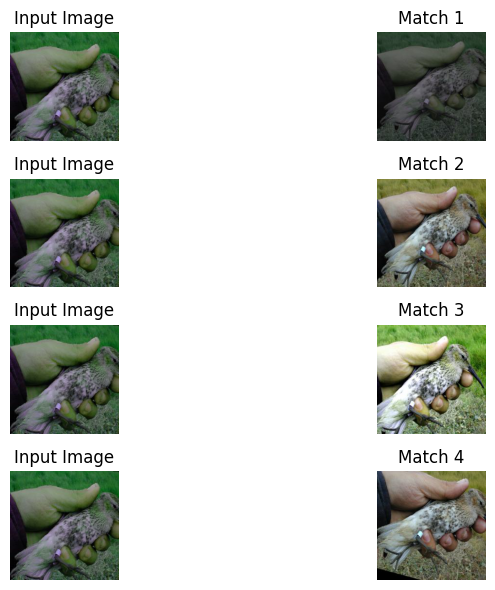

In [57]:
# retrieves top k matches from the database for a given input

score= top_k_matches(image_path=test_img_paths[0], model= backbone_model, k=4)